In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

%matplotlib inline

c:\Users\macie\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hacky code which prevent kernel from dying because of matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Load data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
ds_train

<_OptionsDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Visualise images

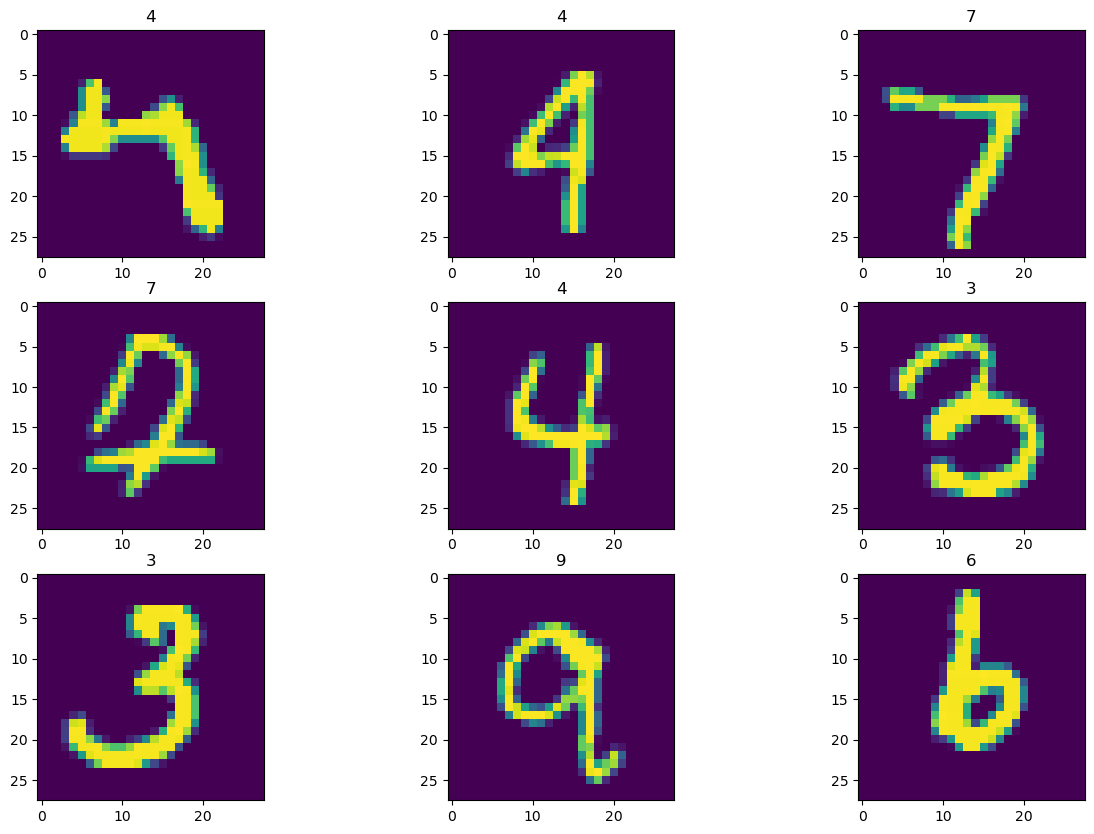

In [4]:

plt.figure(figsize=(15,10))
data_iterator = ds_train.as_numpy_iterator()
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # generate batch of images
 batch = data_iterator.next()
 # convert to unsigned integers for viewing
 image = batch[0].astype('uint8')
 # plot raw pixel data
 plt.imshow(image)
 plt.title(batch[1])
# show the figure

# Split train data into real train an validation sets

In [5]:
ds_training, ds_validation = tf.keras.utils.split_dataset(
    ds_train, left_size=0.75, shuffle=True, seed=17
)

In [6]:
print(len(ds_training), len(ds_validation))

45000 15000


## Scale data

In [7]:
# ds_train = ds_train.map(lambda x,y: (x/255, y))
# ds_test = ds_test.map(lambda x,y: (x/255, y))

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_training = ds_training.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_training = ds_training.cache()
ds_training = ds_training.shuffle(ds_info.splits['train'].num_examples)
ds_training = ds_training.batch(128)
ds_training = ds_training.prefetch(tf.data.AUTOTUNE)

In [8]:
ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [9]:
# number of batches

print(len(ds_validation))
print(len(ds_training))

118
352


# Create and train the model

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu",
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [17]:

from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard()

In [20]:
hist = model.fit(
    ds_training,
    epochs=20,
    validation_data=ds_validation,
    callbacks=[tensorboard_callback, earlystopping]
)

Epoch 1/20


352/352 [==============================] - 27s 75ms/step - loss: 0.0611 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9811
Epoch 2/20
352/352 [==============================] - 32s 90ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0420 - val_sparse_categorical_accuracy: 0.9870
Epoch 3/20
352/352 [==============================] - 27s 75ms/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9839
Epoch 4/20
352/352 [==============================] - 31s 87ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0475 - val_sparse_categorical_accuracy: 0.9863
Epoch 5/20
352/352 [==============================] - 28s 80ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9888
Epoch 6/20
352/352 [==============================] - 28s 79ms/step - loss: 0.0162 - sparse_categoric

# Display train results

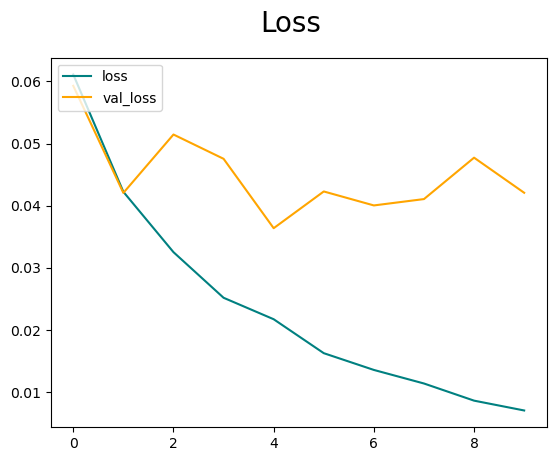

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate on test data

In [50]:
from tensorflow.keras.metrics import Accuracy
import numpy as np

acc = Accuracy()

e = 1

for batch in ds_test.as_numpy_iterator(): 
    X, y = batch
    y_probs = model.predict(X)
    y_hat = [np.argmax(probs) for probs in y_probs]
    acc.update_state(y, y_hat)

1/1 [==============================] - 0s 116ms/step


In [52]:
print(acc.result())

tf.Tensor(0.9894, shape=(), dtype=float32)
